In [1]:
#Qiskit Machine Learning
#A set of tools, algorithms and software for use with IBM QCs to investigate 
#how to use quantum computing to solve machine learning problems.

#Qiskit Aqua: qGAN for Loading Random Distributions
#We have a k-dimensional data sample
#We employ a quantum Generative Adversarial Network (qGAN) 
#to learn the underlying random distribution and 
#to load it into a quantum state:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
start = time.time()
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks.numpy_discriminator import NumpyDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer
from torch import optim


Bad key "text.kerning_factor" on line 4 in
E:\DevelopmentEnvironments\Anaconda3\envs\qiskit_env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


ModuleNotFoundError: No module named 'torch'

In [3]:
#Load Training Data
#First, we need to load the k-dimensional training data samples (here k=1).
#Next, the data resolution is set, i.e. 
#the min/max data values and the number of qubits used to represent each data dimension.

# Number training data samples
N = 500 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
print (real_data)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.])
print (bounds)
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

[ 4.26552917  2.11647282  8.11388427  3.31335901  3.84869628  4.06566393
  0.76767419  2.53219537  1.34075853  1.96294163  5.36560432  5.39441913
  6.14321916  1.26942815  0.66470306  7.62526393  9.17751571  7.43799252
  2.05088272  1.91030137  1.52430458  1.10476751  7.18570633  0.730632
  5.55734375  9.73482418  1.23899264  0.50489431  4.50542331  2.71000779
  2.03839679  2.06028101 11.50601992  2.22095548  0.87282458  1.19028643
  6.0155217   4.49159773  1.18386455  1.4705499   2.46130752  1.9107491
  1.11697877  3.30375615 13.39163369  1.3631658   2.25685928  8.3667373
  6.6776204   0.74295334  1.89075092  0.5879876   2.22428706  2.19513941
 11.90650122  8.73940942  1.07139002  2.74031145  2.31034526  2.85891002
  2.09413898  3.12906271  0.88450254  7.10374913  2.82170008  5.63922419
  4.68631097  2.76106053  5.96927342 21.50000445 34.36006551 13.99108865
  1.0516872   5.04336917  2.16483208  3.63307097  1.67020573  2.26040772
  0.72732909  4.50202679  1.56403744  6.69806716  0.609

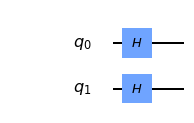

In [4]:
#Initialize the qGAN
#The qGAN consists of a quantum generator, a variational quantum circuit, and a classical discriminator,
#a neural network.
#To implement the quantum generator, we choose a depth-1 variational form that implements 
#R_Y rotations and CZ gates which takes a uniform distribution as an input state. 
#Notably, for k > 1 the generator's parameters must be chosen carefully. 
#For example, the circuit depth should be > 1 
#because higher circuit depths enable the representation of more complex structures.
#The classical discriminator is given by a 3-layer neural network that applies linear transformations, 
#leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. 
#Notably, the neural network is implemented with PyTorch. 
#Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.
#Here, both networks are updated with the ADAM optimization algorithm.

# Set number of training epochs - # of times training process should run
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 200
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
print(qgan)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]  #Since we are using only two qubits

# Set an initial state for the generator circuit
init_state = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
#Create a Quantum Circuit to represent the initial state
init_state.build(qc, q)
qc.draw(output='mpl')

In [5]:
#Create an Initial Distribution from the circuit
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
#Setup the variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])

In [6]:
print(init_distribution)
print(var_form)
print(init_params)
print(g_circuit)

[2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00]


In [26]:
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumpyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)
print(qgan)

In [27]:
#Run the qGAN Training
#During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions: $$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$ and $$ L_D\left(\phi, \theta\right) = \frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$ with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

#Please note that the training will take a while ($\sim 20$ min).

# Run qGAN
qgan.run(quantum_instance)
# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  24.001154828071595  min


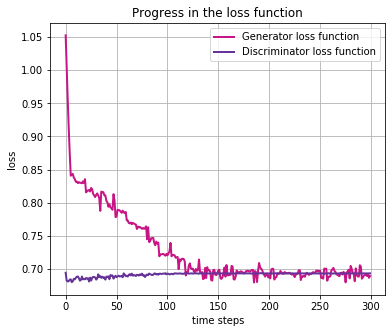

In [28]:
#Training Progress & Outcome
#Now, we plot the evolution of the generator's and the discriminator's loss functions 
#during the training as well as the progress in the relative entropy between the trained and the target distribution.
#Finally, we also compare the cumulative distribution function (CDF) of the trained distribution 
#to the CDF of the target distribution.

# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

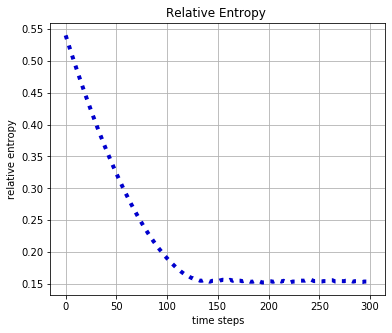

In [29]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

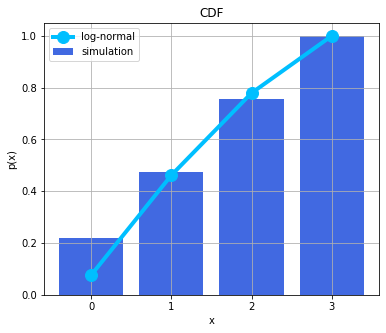

In [30]:
#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()